# Nested Sampling and Compression

In this section we explore how nested sampling performs compression. We'll introduce a tree-like structure for the data representation, and see how that helps us to understand the compression process.

In [11]:
from jaxns.tree_structure import SampleTreeGraph, plot_tree
import numpy as np
import jax.numpy as jnp



In [15]:
def random_tree(n):
    np.random.seed(42)
    log_L = [0]
    parent_idx = []

    for idx in range(n):
        new_log_L = log_L[idx] + np.random.uniform(low=0, high=1-log_L[idx])**4
        log_L.append(new_log_L)
        parent_idx.append(idx)

    for idx in range(n):
        for _ in range(2):
            new_log_L = np.random.uniform(low=log_L[idx], high=1.)
            log_L.append(new_log_L)
            parent_idx.append(idx)

    S = SampleTreeGraph(
        sender_node_idx=jnp.asarray(parent_idx),
        log_L=jnp.asarray(log_L)
    )
    return S



In [16]:
S = random_tree(5)

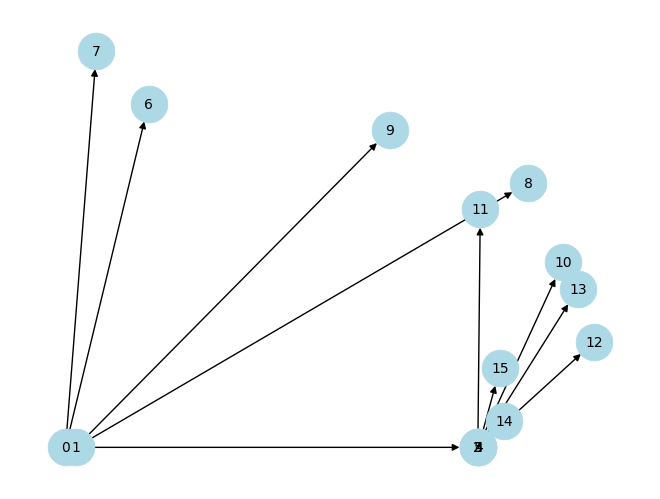

In [17]:
plot_tree(S)

In [18]:
S

SampleTreeGraph(sender_node_idx=Array([0, 1, 2, 3, 4, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4], dtype=int32), log_L=Array([0.        , 0.01967856, 0.7742044 , 0.7749507 , 0.7752801 ,
       0.77528167, 0.15599452, 0.05808361, 0.8688096 , 0.6089645 ,
       0.93408406, 0.7788523 , 0.99322826, 0.9622913 , 0.822997  ,
       0.8161398 ], dtype=float32))

Every sample will be uniformly drawn from a prior subject to the hard likelihood constraint that it's likelihood value is greater than some parent sample's likelihood. This entails a search mechanism to find such a suitable point, and is the source of compression. Therefore, our data structure simply needs to keep track, for each sample, the parent sample whose likelihood contour the given sample is drawn from uniformly.

# Example Tree Structure
| Sample | Parent Sample | Likelihood |
|--------|---------------|------------| 
| 0      | -             | 0          |
| 1      | 0             | 0.1        |
| 2      | 0             | 0.2        |
| 3      | 1             | 0.3        |
| 4      | 2             | 0.4        |

To each sample we can assign an enclosed prior volume, using the aspect of compression. We'll associate with each sample a factor of $t$, which is a compression factor.

In words it's like this. Sample 0 encloses all volume. Samples 1 and 2 are both from parent 0. So, the smaller likelihood is the first to compression by a factor $t$, and then the other. So $X_1=t X_0$, and $X_2 = t^2 X_0$. Sample 3 is from parent 1, so $X_3 = t X_1 = t^2 X_0$. Sample 4 is from parent 2, so $X_4 = t X_2 = t^3 X_0$.

| Sample | Prior Volume |
|--------|--------------|
| 0      | $X_0=1$      | 
| 1      | $X_1=t$      |
| 2      | $X_2=t^2$    |
| 3      | $X_3=t^2$    |
| 4      | $X_4=t^3$    |

